# Machine Learning Immersion Day

This notebook will serve as a template for the overall process of taking a non ideal time series dataset and integrating it into [Amazon Forecast](https://aws.amazon.com/forecast/).

## Overview

1. Introduction to Amazon Forecast
1. Obtaining Your Data
1. Fitting the Data to Forecast
1. Determining Your Forecast Horizon (1st pass)
1. Building Your Predictors
1. Visualizing Predictors
1. Making Decisions
1. Next Steps


## Introduction to Amazon Forecast

If you are not familiar with Amazon Forecast you can learn more about this tool on these pages:

* [Product Page](https://aws.amazon.com/forecast/)
* [GitHub Sample Notebooks](https://github.com/aws-samples/amazon-forecast-samples)
* [Product Docs](https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html)


## Obtaining Your Data

A critical requirement to use Amazon Forecast is to have access to time-series data for your selected use case. To learn more about time series data:

1. [Wikipedia](https://en.wikipedia.org/wiki/Time_series)
1. [Toward's Data Science Primer](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)
1. [O'Reilly Book](https://www.amazon.com/gp/product/1492041653/ref=ppx_yo_dt_b_search_asin_title?ie=UTF8&psc=1)

For this exercise, we use the individual household electric power consumption dataset. (Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.) We aggregate the usage data hourly.

To begin, use Pandas to read the CSV and to show a sample of the data.

To begin the cell below will complete the following:

1. Create a directory for the data files.
1. Download the sample data into the directory.
1. Extract the archive file into the directory.

With the data downloaded, now we will import the Pandas library as well as a few other data science tools in order to inspect the information.

In [1]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import dateutil.parser

With the libraries loaded, start by using the Pandas library to parse the CSV and render a simple dataframe of the historical information provided.

In [2]:
df = pd.read_csv("../data/item-demand-time.csv", dtype = object, names=['timestamp','value','item'])
df.drop(df.loc[df['item']!='client_12'].index, inplace=True)
df.head(3)

,timestamp,value,item
0,2014-01-01 01:00:00,38.34991708126038,client_12
1,2014-01-01 02:00:00,33.5820895522388,client_12
2,2014-01-01 03:00:00,34.41127694859037,client_12


In [3]:
df.describe()

,timestamp,value,item
count,7991,7991,7991
unique,7991,2891,1
top,2014-10-24 22:00:00,45.39800995024875,client_12
freq,1,35,7991


Notice in the output above there are 3 columns of data:

1. The Timestamp
1. A Value
1. An Item

These are the 3 key required pieces of information to generate a forecast with Amazon Forecast. More can be added but these 3 must always remain present.

The dataset happens to span January 01, 2014 to Deceber 31, 2014. For our testing we would like to keep the last month of information in a different CSV. We are also going to save January to November to a different CSV as well.

You may notice a variable named `df` this is a popular convention when using Pandas if you are using the library's dataframe object, it is similar to a table in a database. You can learn more here: https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

The cell below will convert the timestamp field to an index so that we can see the date ranges within the dataframe.

In [5]:
df.set_index('timestamp', inplace=True)

The following cell will show the range of dates now:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7991 entries, 2014-01-01 01:00:00 to 2014-11-29 23:00:00
Data columns (total 2 columns):
value    7991 non-null object
item     7991 non-null object
dtypes: object(2)
memory usage: 187.3+ KB


Now move onto slicing the information to have a validation set and the train and test set.

Given the data ranges from 2014-01-01 01:00:00 to 2014-11-29 23:00:00, first split data from January to October, then save the rest into another dataframe.

The data from January to October will be used by Forecast for the training and test set, and then November to December will be used as the validation set later in this notebook.

In [7]:
train_and_test_df = df.loc['2014-01-01':'2014-11-01']
validation_df = df.loc['2014-11-01':]

Next take a look and confirm the date ranges on each dataframe line up to the timelines described above.

In [8]:
train_and_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7295 entries, 2014-01-01 01:00:00 to 2014-10-31 23:00:00
Data columns (total 2 columns):
value    7295 non-null object
item     7295 non-null object
dtypes: object(2)
memory usage: 171.0+ KB


In [9]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 696 entries, 2014-11-01 00:00:00 to 2014-11-29 23:00:00
Data columns (total 2 columns):
value    696 non-null object
item     696 non-null object
dtypes: object(2)
memory usage: 16.3+ KB


Now export them to CSV files and place them into your `data` folder.

In [10]:
train_and_test_df.to_csv("../data/item-demand-time-train.csv", header=False, index=True)
validation_df.to_csv("../data/item-demand-time-validation.csv", header=False, index=True)

### Uploading your training data to S3

At this time the data is ready to be sent to S3 where Forecast will use it later. The following cells will upload the data to S3.

Please paste the Bucket Name and the Forecast Role ARN from your Cloudformation outputs section


In [12]:
iam = boto3.client("iam")

role_name = "ForecastRoleID-4"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "forecast.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(30) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::518708957550:role/ForecastRoleID-4


At this point thie next thing to do is import a file into Amazon Forecast, however we do not yet have anything in S3, so we will create a bucket, and upload our target file there.

In [14]:
# Replace this bucket name and your Role ARN 

bucket_name = "pandvike-1706"
role_name = role_arn.split("/")[1]

target_time_series_filename ="elec_data/item-demand-time-train.csv"

boto3.Session().resource('s3').Bucket(bucket_name).Object(target_time_series_filename).upload_file("../data/item-demand-time-train.csv")

## Getting Started With Forecast

Now that all of the required data to get started exists, our next step is to build the dataset groups and datasets required for our problem. Inside Amazon Forecast a DatasetGroup is an abstraction that contains all the datasets for a particular collection of Forecasts. There is no information sharing between DatasetGroups so if you'd like to try out various alternatives to the schemas we create below, you could create a new DatasetGroup and make your changes inside its corresponding Datasets.

The order of the process below will be as follows:

1. Create a DatasetGroup for our POC.
1. Create a `Target-Time-Series` Dataset.
1. Attach the Dataset to the DatasetGroup.
1. Import the data into the Dataset.
1. Generate Forecasts with DeepAR+.
1. Query the Forecast.
1. Compare the forecast with the actual. 


The cell below defines a few global settings for our POC with the service.

### Definitions:

1. DATASET_FREQUENCY: How frequently the data is measured in our target_time_series file aka the train and test dataset.
1. TIMESTAMP_FORMAT: The format used for our timestamp.
1. project: Just a string that helps label the assets created later.
1. datasetName: The name of the Dataset that will be created.
1. datasetGroupName: The name of the dataset group that will be created.

In [15]:
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

project = 'forecast_immersion_day_20'
datasetName= project+'_ds_20'
datasetGroupName= project +'_dsg_20'

Now using the metada stored on this instance of a SageMaker Notebook determine the region we are operating in. If you are using a Jupyter Notebook outside of SageMaker simply define `region` as the string that indicates the region you would like to use for Forecast and S3.

In [16]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

eu-west-1


Configure your AWS APIs

In [17]:
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')


Create the DatasetGroup, this will be the isolation level for all further work during this immersion day


In [18]:
# Create the DatasetGroup
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="CUSTOM",
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

The cell below will describe the DatasetGroup, not much is interesting until we add a dataset later.

In [19]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'forecast_immersion_day_20_dsg_20',
 'DatasetGroupArn': 'arn:aws:forecast:eu-west-1:518708957550:dataset-group/forecast_immersion_day_20_dsg_20',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 6, 17, 16, 7, 7, 151000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 6, 17, 16, 7, 7, 151000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '5e7a023c-43d4-4125-ac30-dfed181d7c49',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 17 Jun 2020 16:07:09 GMT',
   'x-amzn-requestid': '5e7a023c-43d4-4125-ac30-dfed181d7c49',
   'content-length': '287',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}


Datasets inside Amazon Forecast require a schema to be defined, there are several that already exist within the service but in this immersion day you will create one from scratch. Note the structure of the dictionary below, it should mirror the CSV file you created earlier. This schema will be used when importing data to make sure that it is parsed correctly from your CSV into a format which Forecast can use for building your models and inferences later.


In [20]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}



Once the schema has been defined you can now create the dataset:


In [21]:
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)



Again the cell below will give the metrics about the Dataset now that it has been created.


In [22]:
target_datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=target_datasetArn)

{'DatasetArn': 'arn:aws:forecast:eu-west-1:518708957550:dataset/forecast_immersion_day_20_ds_20',
 'DatasetName': 'forecast_immersion_day_20_ds_20',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 6, 17, 16, 7, 15, 753000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 6, 17, 16, 7, 15, 753000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '3a62cd2f-f98d-45d8-a886-22ff1f312001',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 17 Jun 2020 16:07:19 GMT',
   'x-amzn-requestid': '3a62cd2f-f98d-45d8-a886-22ff1f312001',
   'content-length': '523',
   'connection': 'keep-al



Before the Dataset can be used, it needs to be attached to a DatasetGroup, the cell below will do that.


In [23]:
# Attach the Dataset to the Dataset Group:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[target_datasetArn])

{'ResponseMetadata': {'RequestId': '176ebbdc-3ce2-4bda-bd6c-179cabc7a958',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 17 Jun 2020 16:07:23 GMT',
   'x-amzn-requestid': '176ebbdc-3ce2-4bda-bd6c-179cabc7a958',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}



At long last, it is time to import data into Amazon Forecast, the cell below will start the import process for you using all of the resources that you created earlier.


In [24]:
# Finally we can call import the dataset
target_s3DataPath = "s3://"+bucket_name+"/"+target_time_series_filename
datasetImportJobName = 'DSIMPORT_JOB_TARGET'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=target_datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":target_s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )



To see the status immediately after creating the job run the cell below:


In [25]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:eu-west-1:518708957550:dataset-import-job/forecast_immersion_day_20_ds_20/DSIMPORT_JOB_TARGET



The cell below will run and poll every 30 seconds until the import process has completed. This process will take around 5 minutes to complete so feel free to stretch your legs if needed. After it completes the next step is to start building models, AKA Predictors with Amazon Forecast.

Once it prints ACTIVE you are ready to move onto the next section.


In [26]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE



## Creating Predictors

Given that that our data is hourly and we want to generate a forecast on the hour, we will se the frequency to H or hourly. Amazon Forecast does limit your horizon to 500 of whatever your frequency interval is, that would mean 500 hours here or around 20 days into the future. For the purposes of this exercise though we are going to set the horizon to 24 hours.

The cells below will define a few variables to be used with all of our models. Then there will be an API call to create each Predictor where they are based on ARIMA, Prophet, and DeepAR+ respectfully.

### Definitions
- forecast_frequency: The interval for the forecast, in this case hourly.
- forecast_horizon: How many of the intervals to predict in a forecast.
- number_of_backtest_windows: How many validation windows.
- backtest_window_offset: How long the validation window is.


In [27]:
forecastHorizon = 24
NumberOfBacktestWindows = 1
BackTestWindowOffset = 24
ForecastFrequency = "H"

Next you will need to define the ARN for DeepAR+ algorithm so that you can train a predictor with it.

In [28]:
deepAR_Plus_algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'

Now, let us create a predictor which will build using the DeepAR+ algorithm. 

In [29]:
# DeepAR+ Specifics
deepAR_plus_predictorName= project+'_deeparp_algo_20'

While creating the predictor, you interact with Amazon Forecast APIs. For documentation on which all parameters are required in the `create_predictor` method, please have a look at: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/forecast.html#ForecastService.Client.create_predictor


If you want Amazon Forecast to evaluate each algorithm and choose the one that minimizes the objective function, set `PerformAutoML` to `True`. The objective function is defined as the mean of the weighted p10, p50, and p90 quantile losses. 

When AutoML is enabled, the following properties are disallowed:
- AlgorithmArn
- HPOConfig
- PerformHPO
- TrainingParameters

And if you set `PerformAutoML` to False then you need to supply all the above parameters.


In [30]:
# Build DeepAR+:
deeparp_create_predictor_response=forecast.create_predictor(PredictorName=deepAR_plus_predictorName, 
                                                  AlgorithmArn=deepAR_Plus_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )

The predictor creation takes 20-25 minutes minutes or so to complete. So feel free to take a break here here, go grab a pint, really anything that is going to kill some time.

The following while loop keeps track of the DeepAR+ predictor progress

In [31]:
while True:
    status = forecast.describe_predictor(PredictorArn=deeparp_create_predictor_response['PredictorArn'])['Status']
    print(status)
    if status != 'ACTIVE' and status != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRE

## Examine the Predictors

Once the Predictor is in an Active state you can get metrics about it to better understand its accuracy and behavior. These are computed based on the hold out periods we defined when building the Predictor. The metrics are meant to guide our decisions when we use a particular Predictor to generate a forecast


In [32]:
# DeepAR+ Metrics
deeparp_arn = deeparp_create_predictor_response['PredictorArn']
deeparp_metrics = forecast.get_accuracy_metrics(PredictorArn=deeparp_arn)
pp = pprint.PrettyPrinter()
pp.pprint(deeparp_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 9.500321878499488,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.03348877158850566,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.0712176171278786,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.033733314445292546,
                                                                                          'Quantile': 0.1}]}},
                                       

## Generate a Forecast

The next phase is to generate a Forecast from the Predictor so we can see the results and understand visually how the model is performing.

In [33]:
# DeepAR+
deeparp_forecastName = project+'_deeparp_algo_forecast'
deeparp_create_forecast_response=forecast.create_forecast(ForecastName=deeparp_forecastName,
                                                  PredictorArn=deeparp_arn)
deeparp_forecast_arn = deeparp_create_forecast_response['ForecastArn']

In [35]:
while True:
    status = forecast.describe_forecast(ForecastArn=deeparp_forecast_arn)['Status']
    print(status)
    if status != 'ACTIVE' and status != 'CREATE_FAILED':
        sleep(30)
    else:
        break

ACTIVE


### Get Forecast

Once created, the forecast results are ready and you view them.


In [36]:
forecastResponse = forecast_query.query_forecast(
    ForecastArn=deeparp_forecast_arn,
    Filters={"item_id":"client_12"}
)

pp = pprint.PrettyPrinter()
pp.pprint(forecastResponse)

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2014-11-01T00:00:00',
                                       'Value': 47.710391998291016},
                                      {'Timestamp': '2014-11-01T01:00:00',
                                       'Value': 46.163719177246094},
                                      {'Timestamp': '2014-11-01T02:00:00',
                                       'Value': 45.887813568115234},
                                      {'Timestamp': '2014-11-01T03:00:00',
                                       'Value': 40.065799713134766},
                                      {'Timestamp': '2014-11-01T04:00:00',
                                       'Value': 39.40488815307617},
                                      {'Timestamp': '2014-11-01T05:00:00',
                                       'Value': 43.04194641113281},
                                      {'Timestamp': '2014-11-01T06:00:00',
                                       'Value': 42.876983642578

## Evaluating Your Forecast

So far you have prepared your data, and generated your first Forecast. Now is the time to pull down the predictions from this Predictor, and compare them to the actual observed values. This will let us know the impact of accuracy based on the Forecast.

You can extend the approaches here to compare multiple models or predictors and to determine the impact of improved accuracy on your use case.

Setup
* Plotting the Actual Results
* Plotting the Prediction
* Comparing the Prediction to Actual Results

### Plotting the Actual Results

we are now going to select a given date and customer from that dataframe and are going to plot the actual usage data for that customer.

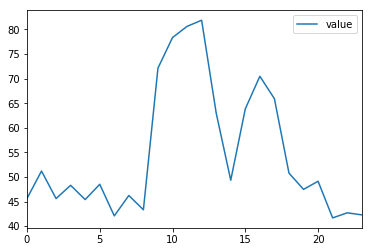

In [37]:
actual_df = pd.read_csv("../data/item-demand-time-validation.csv", names=['timestamp','value','item'])
actual_df.head()

#Next we need to reduce the data to just the day we wish to plot, which is the First of November 2014.
actual_df = actual_df[(actual_df['timestamp'] >= '2014-11-01') & (actual_df['timestamp'] < '2014-11-02')]


#Lastly, only grab the items for client_12

actual_df = actual_df[(actual_df['item'] == 'client_12')]
actual_df.head()
actual_df.plot()


### Plotting the Prediction:

Next we need to convert the JSON response from the Predictor to a dataframe that we can plot.


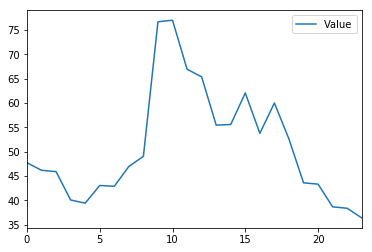

In [38]:
# Generate DF 
prediction_df_p10 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p10'])
prediction_df_p10.head()

# Plot
prediction_df_p10.plot()

The above merely did the p10 values, now do the same for p50 and p90.

In [41]:
prediction_df_p50 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p50'])
prediction_df_p90 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p90'])


### Comparing the Prediction to Actual Results

After obtaining the dataframes the next task is to plot them together to determine the best fit.


In [39]:


# We start by creating a dataframe to house our content, here source will be which dataframe it came from
results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])



# Import the observed values into the dataframe:

for index, row in actual_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['value'], 'source': 'actual'} , ignore_index=True)
    
    

# To show the new dataframe
results_df.head()

,timestamp,value,source
0,2014-11-01 00:00:00,45.605307,actual
1,2014-11-01 01:00:00,51.202322,actual
2,2014-11-01 02:00:00,45.605307,actual
3,2014-11-01 03:00:00,48.300166,actual
4,2014-11-01 04:00:00,45.398010,actual


In [40]:
# Now add the P10, P50, and P90 Values
for index, row in prediction_df_p10.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'} , ignore_index=True)
for index, row in prediction_df_p50.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)
for index, row in prediction_df_p90.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'} , ignore_index=True)

NameError: name 'prediction_df_p50' is not defined

In [ ]:
results_df

Now lets draw a comparison of p10, p50 and p90 with the actual consumption values to see which of these quantiles is best.

In [ ]:
pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")

pivot_df

In [ ]:
pivot_df.plot(figsize=(20,10))

### Cleanup

The last thing to do now is to tear down the resources that you created in this exercise. The cell below will save a series of variables that are useful in this process. Execute it and then open the Cleanup.ipynb notebook to finish this process.